In [1]:
import os
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL_proj' # change this directory to yours
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Planet')
print(os.listdir(GOOGLE_DRIVE_PATH))

['DL_proj', 'Planet', 'cnn_model.pth', 'cnn_model_30epochs.pth', 'processed_data_clouds.pkl', 'processed_data.pkl', 'dense_net_model.pth', 'vit_model.pth', 'cnn_model_0.5cloudfilter.pth', 'cnn_model_cleandata.pth', 'vit_model-b16.pth', 'figures']


In [19]:
processed_data = pd.read_pickle(os.path.join(GOOGLE_DRIVE_PATH,'processed_data.pkl'))
processed_data = pd.DataFrame(processed_data)
processed_data.set_index(['site', 'date'], inplace=True)
processed_data = processed_data[processed_data.target >= 0]

processed_data_clouds = pd.read_pickle(os.path.join(GOOGLE_DRIVE_PATH,'processed_data_clouds.pkl'))
processed_data_clouds = pd.DataFrame(processed_data_clouds)
processed_data_clouds.set_index(['site', 'date'], inplace=True)
processed_data_clouds = processed_data_clouds[processed_data_clouds.target >= 0]

In [5]:
processed_data_clouds.head()

raster  \
site       date                                                            
0136219503 2018-06-11  [[[0, 0, 124, 161, 141, 133, 141, 154, 146, 16...   
           2018-06-14  [[[0, 0, 217, 254, 264, 228, 239, 234, 232, 24...   
           2018-06-16  [[[0, 0, 165, 174, 190, 203, 194, 180, 182, 21...   
           2018-06-18  [[[0, 0, 492, 479, 436, 423, 432, 406, 390, 39...   
           2018-06-29  [[[0, 0, 4600, 4735, 4885, 5040, 5180, 5425, 5...   

                       target  
site       date                
0136219503 2018-06-11     1.4  
           2018-06-14     1.4  
           2018-06-16     1.4  
           2018-06-18     1.5  
           2018-06-29     1.6

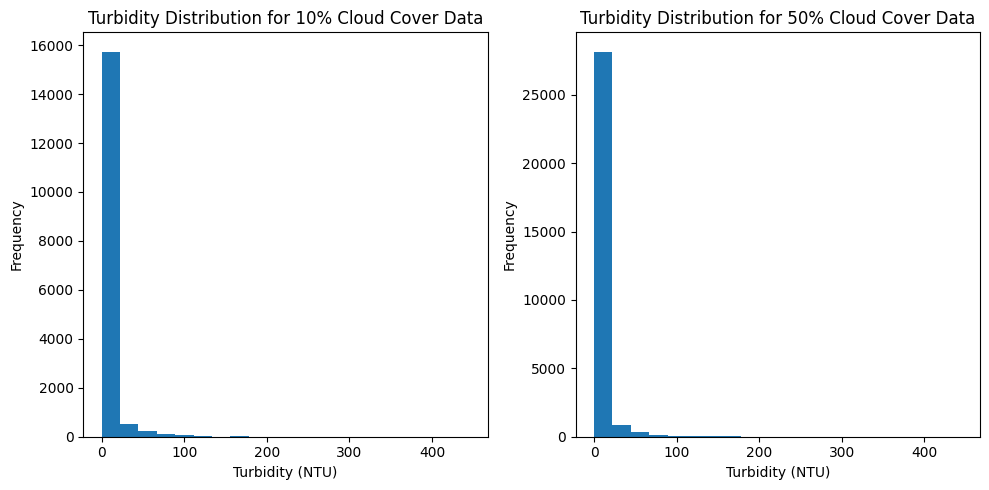

In [22]:
import matplotlib.pyplot as plt
hist_path = os.path.join(GOOGLE_DRIVE_PATH, 'figures', 'turbidity_distributions.png')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(processed_data['target'], bins=20)
axes[0].set_title('Turbidity Distribution for 10% Cloud Cover Data')
axes[0].set_xlabel('Turbidity (NTU)')
axes[0].set_ylabel('Frequency')
axes[1].hist(processed_data_clouds['target'], bins=20)
axes[1].set_title('Turbidity Distribution for 50% Cloud Cover Data')
axes[1].set_xlabel('Turbidity (NTU)')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(hist_path, dpi=400)
plt.show()

#### Data preprocessing and cleaning

#### Normalize the data

In [7]:
def zscore_normalize(data):
    mean_values, std_values = [], []

    # Calculate mean and standard deviation for each layer across all rasters
    for array in data['raster']:
        mean_per_layer = np.mean(array, axis=(1, 2))  # Mean per layer (band)
        std_per_layer = np.std(array, axis=(1, 2))    # Standard deviation per layer (band)
        mean_values.append(mean_per_layer)
        std_values.append(std_per_layer)

    mean_values = np.array(mean_values)
    std_values = np.array(std_values)

    # Get overall mean and standard deviation for each band
    overall_mean = np.mean(mean_values, axis=0)
    overall_std = np.mean(std_values, axis=0)

    # Standardize raster data
    standardized_rasters = []
    for raster in data['raster']:
        standardized = (raster - overall_mean[:, None, None]) / overall_std[:, None, None]
        standardized_rasters.append(standardized)

    # Standardize target data
    target_mean = np.mean(data['target'])
    target_std = np.std(data['target'])
    standardized_targets = (data['target'] - target_mean) / target_std

    # Update the dataframe with standardized values
    data['raster'] = standardized_rasters
    data['target'] = standardized_targets

    return data, overall_mean, overall_std, target_mean, target_std

def reverse_zscore_normalize(normalized_raster, overall_mean, overall_std):
  # Revert raster standardization
  unstandardized_raster = normalized_raster * overall_std[:, None, None] + overall_mean[:, None, None]
  return unstandardized_raster

def reverse_zscore_normalize_target(normalized_target, target_mean, target_std):
    # Revert target standardization
    unstandardized_target = normalized_target * target_std + target_mean
    return unstandardized_target

unnormalized_data = processed_data.copy()
processed_data, overall_mean, overall_std, target_mean, target_std = zscore_normalize(processed_data)

In [8]:
unnormalized_data_clouds = processed_data_clouds.copy()
processed_data_clouds, overall_mean_clouds, overall_std_clouds, target_mean_clouds, target_std_clouds = zscore_normalize(processed_data_clouds)


In [9]:
processed_data.head()

raster  \
site       date                                                            
0136219503 2018-06-11  [[[-1.2430485180047524, -1.2430485180047524, -...   
           2018-06-14  [[[-1.2430485180047524, -1.2430485180047524, -...   
           2018-06-16  [[[-1.2430485180047524, -1.2430485180047524, -...   
           2018-07-02  [[[-1.2430485180047524, -1.2430485180047524, -...   
           2018-07-02  [[[-1.2430485180047524, -1.2430485180047524, -...   

                         target  
site       date                  
0136219503 2018-06-11 -0.329211  
           2018-06-14 -0.329211  
           2018-06-16 -0.329211  
           2018-07-02 -0.335077  
           2018-07-02 -0.335077

In [10]:
unnormalized_data_clouds.head()

raster  \
site       date                                                            
0136219503 2018-06-11  [[[0, 0, 124, 161, 141, 133, 141, 154, 146, 16...   
           2018-06-14  [[[0, 0, 217, 254, 264, 228, 239, 234, 232, 24...   
           2018-06-16  [[[0, 0, 165, 174, 190, 203, 194, 180, 182, 21...   
           2018-06-18  [[[0, 0, 492, 479, 436, 423, 432, 406, 390, 39...   
           2018-06-29  [[[0, 0, 4600, 4735, 4885, 5040, 5180, 5425, 5...   

                       target  
site       date                
0136219503 2018-06-11     1.4  
           2018-06-14     1.4  
           2018-06-16     1.4  
           2018-06-18     1.5  
           2018-06-29     1.6

In [11]:
processed_data.describe()
pd.isna(processed_data.target).sum()
print(len(processed_data))

16699


In [12]:
processed_data.dropna(inplace=True)
unnormalized_data.dropna(inplace=True)
processed_data_clouds.dropna(inplace=True)
unnormalized_data_clouds.dropna(inplace=True)

In [14]:
print(len(processed_data))
print(len(processed_data_clouds))

16699
29639


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

def resize_and_pad_raster(raster, target_size):
    # Resize raster to the target shape by keeping the aspect ratio
    c, h, w = raster.shape
    scale = min(target_size[0] / h, target_size[1] / w)  # Scale to fit within target_size
    new_h, new_w = int(h * scale), int(w * scale)

    # Resize while maintaining aspect ratio
    resized = np.zeros((c, new_h, new_w))
    for i in range(c):  # Resize each band individually
        resized[i] = cv2.resize(raster[i], (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Calculate padding for each axis to match target size
    pad_h = (target_size[0] - new_h) // 2
    pad_w = (target_size[1] - new_w) // 2
    padding = ((0, 0), (pad_h, target_size[0] - new_h - pad_h), (pad_w, target_size[1] - new_w - pad_w))

    # Apply zero padding
    padded_raster = np.pad(resized, padding, mode='constant', constant_values=0)
    return padded_raster

class RasterDataset(Dataset):
    def __init__(self, rasters, targets, target_size=(64, 64)):
        self.rasters = rasters
        self.targets = targets
        self.target_size = target_size

    def __len__(self):
        return len(self.rasters)

    def __getitem__(self, idx):
        raster = self.rasters.iloc[idx]
        target = self.targets.iloc[idx]

        # resize and pad raster
        raster = resize_and_pad_raster(raster, self.target_size)
        raster_tensor = torch.tensor(raster, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        return raster_tensor, target_tensor

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    processed_data['raster'],
    processed_data['target'],
    test_size=0.2,
    random_state=42
)

X_train_unnorm, X_test_unnorm, y_train_unnorm, y_test_unnorm = train_test_split(
    unnormalized_data['raster'],
    unnormalized_data['target'],
    test_size=0.2,
    random_state=42
)

# Create datasets and dataloaders
train_dataset = RasterDataset(X_train, y_train)
test_dataset = RasterDataset(X_test, y_test)
train_dataset_unnorm = RasterDataset(X_train_unnorm, y_train_unnorm)
test_dataset_unnorm = RasterDataset(X_test_unnorm, y_test_unnorm)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader_unnorm = DataLoader(train_dataset_unnorm, batch_size=32, shuffle=True)
test_loader_unnorm = DataLoader(test_dataset_unnorm, batch_size=32, shuffle=False)


In [ ]:
X_train_clouds, X_test_clouds, y_train_clouds, y_test_clouds = train_test_split(
    processed_data_clouds['raster'],
    processed_data_clouds['target'],
    test_size=0.2,
    random_state=42
)

X_train_unnorm_clouds, X_test_unnorm_clouds, y_train_unnorm_clouds, y_test_unnorm_clouds = train_test_split(
    unnormalized_data_clouds['raster'],
    unnormalized_data_clouds['target'],
    test_size=0.2,
    random_state=42
)

# Create datasets and dataloaders
train_dataset_clouds = RasterDataset(X_train_clouds, y_train_clouds)
test_dataset_clouds = RasterDataset(X_test_clouds, y_test_clouds)
train_dataset_unnorm_clouds = RasterDataset(X_train_unnorm_clouds, y_train_unnorm_clouds)
test_dataset_unnorm_clouds = RasterDataset(X_test_unnorm_clouds, y_test_unnorm_clouds)

train_loader_clouds = DataLoader(train_dataset_clouds, batch_size=32, shuffle=True)
test_loader_clouds = DataLoader(test_dataset_clouds, batch_size=32, shuffle=False)
train_loader_unnorm_clouds = DataLoader(train_dataset_unnorm_clouds, batch_size=32, shuffle=True)
test_loader_unnorm_clouds = DataLoader(test_dataset_unnorm_clouds, batch_size=32, shuffle=False)

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images_np = images.numpy()
print("Max pixel value after normalization (train):", np.max(images_np))
print("Mean pixel value after normalization (train):", np.mean(images_np))
print("Standard deviation after normalization (train):", np.std(images_np))

Max pixel value after normalization (train): 24.36005
Mean pixel value after normalization (train): 0.12544142
Standard deviation after normalization (train): 1.8077357


In [ ]:
data_iter_unnorm = iter(train_loader_unnorm)

In [ ]:
images_unnorm, labels_unnorm = next(data_iter_unnorm)

In [ ]:
images_unnorm_clouds, labels_unnorm_clouds = next(iter(train_loader_unnorm_clouds))

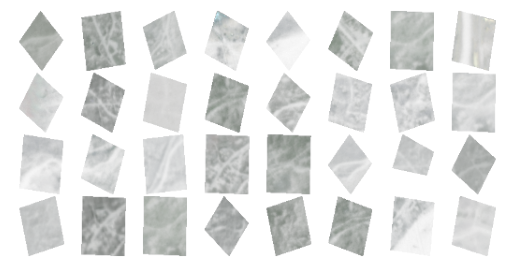

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def imshow_grid(images, fpath, mean=None, std=None):

    # Make a grid of images
    grid_img = torchvision.utils.make_grid(images, nrow=8)  # nrow=8 gives a grid with 8 images per row

    # Convert images to a grid of numpy arrays
    npimg = grid_img.numpy().transpose((1, 2, 0))

    if mean is not None and std is not None:
        npimg = reverse_zscore_normalize(npimg, mean, std)

    def scale(band):
        max_val = np.max(band)
        return band / max_val

    # Split channels and apply scaling
    red = scale(npimg[:, :, 0])
    green = scale(npimg[:, :, 1])
    blue = scale(npimg[:, :, 2])
    nir = scale(npimg[:, :, 3]) if npimg.shape[2] > 3 else np.zeros_like(blue)

    # Stack into RGB-NIR for display if NIR is available
    rgb_nir = np.dstack((red, green, blue, nir))

    # Display the image
    plt.imshow(rgb_nir)
    plt.axis('off')
    plt.savefig(fpath, dpi=400)
    plt.show()

path = os.path.join(GOOGLE_DRIVE_PATH,'image_batch_noClouds.png')
imshow_grid(images_unnorm, path)
# imshow_grid(images, mean=overall_mean, std=overall_std)

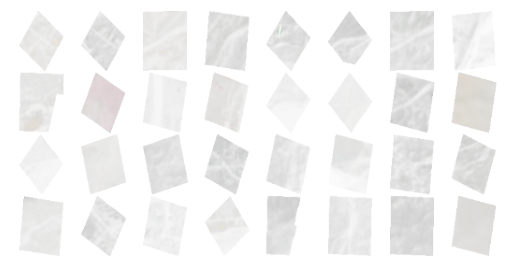

In [ ]:
path_clouds = os.path.join(GOOGLE_DRIVE_PATH,'image_batch_Clouds.png')
imshow_grid(images_unnorm_clouds, path_clouds)

In [ ]:
#BASIC CNN
import torch
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Define the CNN layers
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Define a fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)  # Output one value for regression (turbidity)

        # Define pooling and activation
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers followed by pooling and activation
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))

        # Output layer
        x = self.fc2(x)
        # x = self.relu(x)

        return x

In [ ]:
# Train on cloudy data
# Save model here
model_path = os.path.join(GOOGLE_DRIVE_PATH, 'cnn_model_0.5cloudfilter.pth')

# Initialize
model = CNNModel()
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# First try and load saved model
try:
    # Try loading the model if it exists
    model = torch.load(model_path)
    model.eval()  # Ensure model is in evaluation mode if loaded
    print(f"Model loaded successfully from {model_path}")
except (FileNotFoundError, RuntimeError) as e:
  print('No pretrained model found, training a new model.')
  #Training the CNN
  num_epochs = 20
  loss_history = []
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for i, (rasters, targets) in enumerate(train_loader_clouds):
          rasters, targets = rasters.to(device), targets.to(device)

          # Zero grad
          optimizer.zero_grad()

          # Forward
          outputs = model(rasters)
          loss = criterion(outputs, targets.view(-1, 1))  # Ensure targets have the right shape

          # Backward
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')
      loss_history.append(running_loss / len(train_loader))

# Save the trained model
torch.save(model, model_path)

Model loaded successfully from drive/MyDrive/DL_proj/cnn_model_0.5cloudfilter.pth


<ipython-input-129-9542b2cae72e>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


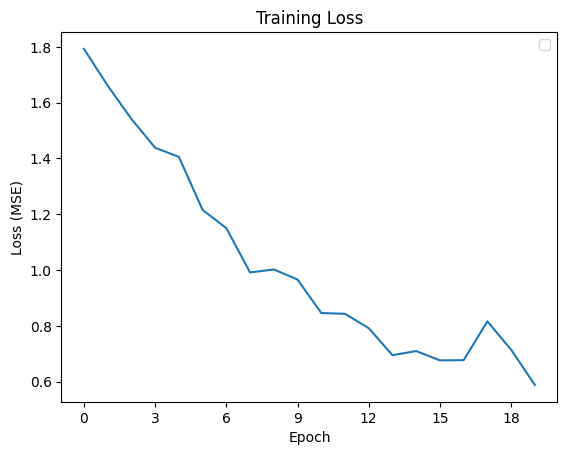

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.xticks(np.arange(0, num_epochs+1, 3))
plt.title('Training Loss')
# plt.vlines(20, 0, 1, color='red', linestyle='--', label='Early stopping')
plt.legend()
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'CNN_training_loss_clouds.png'), dpi=400)
plt.show()

In [ ]:
# Evaluation on the test set
model.eval()
test_loss = 0.0

outputs_history = []
targets_history = []

with torch.no_grad():
    for rasters, targets in test_loader_clouds:
        rasters, targets = rasters.to(device), targets.to(device)

        # Forward pass
        outputs = model(rasters)
        loss = criterion(outputs, targets.view(-1, 1))  # Calculate loss

        test_loss += loss.item()

        # Append outputs and targets to lists
        outputs_history.extend(outputs.cpu().numpy())  # Move outputs to CPU and convert to numpy
        targets_history.extend(targets.cpu().numpy())  # Move targets to CPU and convert to numpy


print(f'Test Loss: {test_loss / len(test_loader)}')

Test Loss: 0.7575964504764193


In [ ]:
# Unnormalize targets ()
outputs_history_unnorm = reverse_zscore_normalize_target(np.array(outputs_history), target_mean_clouds, target_std_clouds)
targets_history_unnorm = reverse_zscore_normalize_target(np.array(targets_history), target_mean_clouds, target_std_clouds)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

rmse = np.sqrt(mean_squared_error(targets_history_unnorm, outputs_history_unnorm))
print(f'RMSE: {rmse}')

r2 = r2_score(targets_history_unnorm, outputs_history_unnorm)
print(f'R^2 Score: {r2}')

RMSE: 9.805471420288086
R^2 Score: 0.4452970623970032


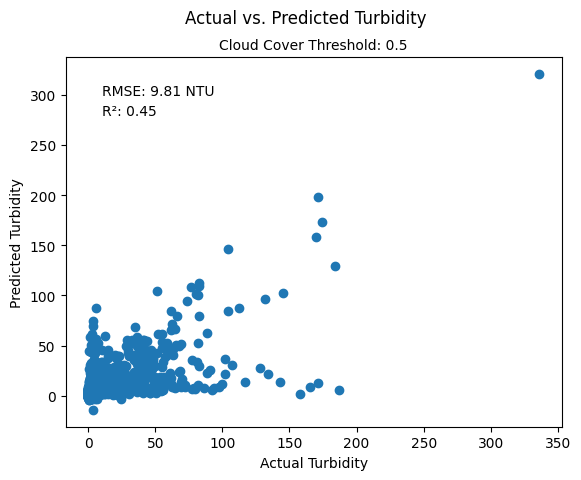

In [ ]:
plt.scatter(targets_history_unnorm, outputs_history_unnorm)
plt.xlabel('Actual Turbidity')
plt.ylabel('Predicted Turbidity')
plt.suptitle('Actual vs. Predicted Turbidity')
plt.title('Cloud Cover Threshold: 0.5', fontsize=10)
plt.text(10, 300, f'RMSE: {9.81} NTU')
plt.text(10, 280, f'R²: {round(r2, 2)}')
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'actual_vs_predicted_turbidity_clouds.png'), dpi=400)
plt.show()

In [ ]:
high_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value > 150]
low_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value <= 150]
high_turb_targets = [targets_history_unnorm[i] for i in high_turb_inds]
low_turb_targets = [targets_history_unnorm[i] for i in low_turb_inds]
high_turb_outputs = [outputs_history_unnorm[i] for i in high_turb_inds]
low_turb_outputs = [outputs_history_unnorm[i] for i in low_turb_inds]

high_turb_rmse = np.sqrt(mean_squared_error(high_turb_targets, high_turb_outputs))
print(f'RMSE: {high_turb_rmse}')

low_turb_rmse = np.sqrt(mean_squared_error(low_turb_targets, low_turb_outputs))
print(f'RMSE: {low_turb_rmse}')

high_turb_r2 = r2_score(high_turb_targets, high_turb_outputs)
print(f'R² Score: {high_turb_r2}')

low_turb_r2 = r2_score(low_turb_targets, low_turb_outputs)
print(f'R² Score: {low_turb_r2}')

RMSE: 111.08187866210938
RMSE: 8.805191993713379
R² Score: -3.5543244857274106
R² Score: 0.34068840186168436


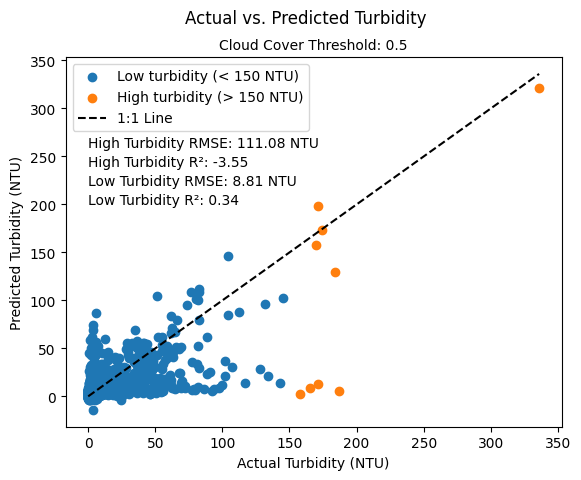

In [ ]:
plt.scatter(low_turb_targets, low_turb_outputs, label='Low turbidity (< 150 NTU)')
plt.scatter(high_turb_targets, high_turb_outputs, label='High turbidity (> 150 NTU)')

# Calculate the range for the 1:1 line
min_value = min(min(low_turb_targets), min(high_turb_targets))
max_value = max(max(low_turb_targets), max(high_turb_targets))

# Plot the 1:1 line
plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='1:1 Line')

# Labels, legend, title, and text
plt.xlabel('Actual Turbidity (NTU)')
plt.ylabel('Predicted Turbidity (NTU)')
plt.legend(loc='best')
plt.suptitle('Actual vs. Predicted Turbidity')
plt.title('Cloud Cover Threshold: 0.5', fontsize=10)
plt.text(0, 260, f'High Turbidity RMSE: {111.08} NTU')
plt.text(0, 240, f'High Turbidity R²: {round(high_turb_r2, 2)}')
plt.text(0, 220, f'Low Turbidity RMSE: {8.81} NTU')
plt.text(0, 200, f'Low Turbidity R²: {round(low_turb_r2, 2)}')

# Save and show the plot
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH, 'actual_vs_predicted_turbidity_highvslow_clouds.png'), dpi=400)
plt.show()

In [ ]:
# Train on cloudy data
# Save model here
model_path = os.path.join(GOOGLE_DRIVE_PATH, 'cnn_model_cleandata.pth')

# Initialize
model = CNNModel()
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# First try and load saved model
try:
    # Try loading the model if it exists
    model = torch.load(model_path)
    model.eval()  # Ensure model is in evaluation mode if loaded
    print(f"Model loaded successfully from {model_path}")
except (FileNotFoundError, RuntimeError) as e:
  print('No pretrained model found, training a new model.')
  #Training the CNN
  num_epochs = 20
  loss_history = []
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for i, (rasters, targets) in enumerate(train_loader):
          rasters, targets = rasters.to(device), targets.to(device)

          # Zero grad
          optimizer.zero_grad()

          # Forward
          outputs = model(rasters)
          loss = criterion(outputs, targets.view(-1, 1))  # Ensure targets have the right shape

          # Backward
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')
      loss_history.append(running_loss / len(train_loader))

# Save the trained model
torch.save(model, model_path)

Model loaded successfully from drive/MyDrive/DL_proj/cnn_model_cleandata.pth


<ipython-input-140-d3f1ff07f36c>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


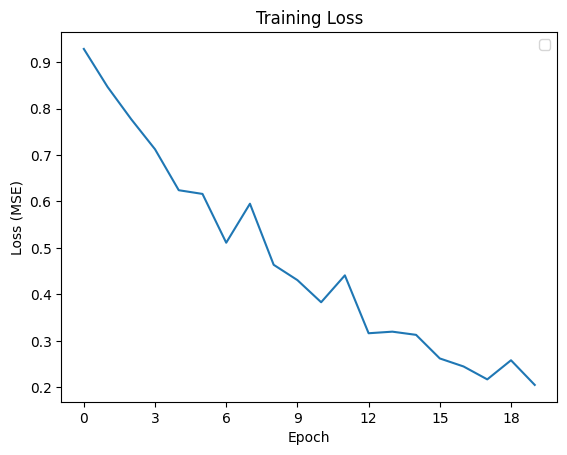

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.xticks(np.arange(0, num_epochs+1, 3))
plt.title('Training Loss')
# plt.vlines(20, 0, 1, color='red', linestyle='--', label='Early stopping')
plt.legend()
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'CNN_training_loss_clean.png'), dpi=400)
plt.show()

In [ ]:
# Evaluation on the test set
model.eval()
test_loss = 0.0

outputs_history = []
targets_history = []

with torch.no_grad():
    for rasters, targets in test_loader:
        rasters, targets = rasters.to(device), targets.to(device)

        # Forward pass
        outputs = model(rasters)
        loss = criterion(outputs, targets.view(-1, 1))  # Calculate loss

        test_loss += loss.item()

        # Append outputs and targets to lists
        outputs_history.extend(outputs.cpu().numpy())  # Move outputs to CPU and convert to numpy
        targets_history.extend(targets.cpu().numpy())  # Move targets to CPU and convert to numpy


print(f'Test Loss: {test_loss / len(test_loader)}')

Test Loss: 0.39830209501087666


In [ ]:
# Unnormalize targets ()
outputs_history_unnorm = reverse_zscore_normalize_target(np.array(outputs_history), target_mean, target_std)
targets_history_unnorm = reverse_zscore_normalize_target(np.array(targets_history), target_mean, target_std)

In [ ]:
rmse = np.sqrt(mean_squared_error(targets_history_unnorm, outputs_history_unnorm))
print(f'RMSE: {rmse}')

r2 = r2_score(targets_history_unnorm, outputs_history_unnorm)
print(f'R^2 Score: {r2}')

RMSE: 10.773841857910156
R^2 Score: 0.6404427289962769


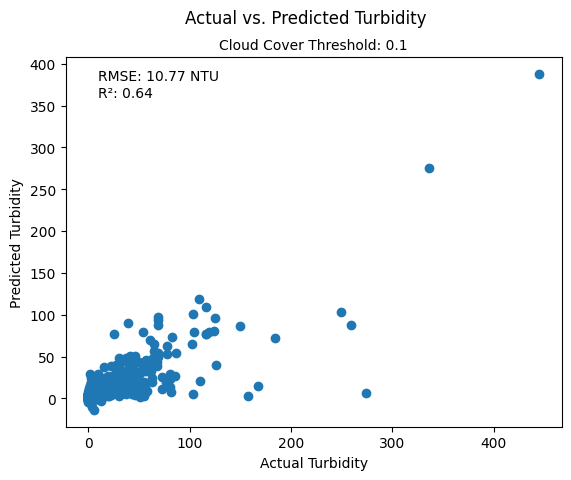

In [ ]:
plt.scatter(targets_history_unnorm, outputs_history_unnorm)
plt.xlabel('Actual Turbidity')
plt.ylabel('Predicted Turbidity')
plt.suptitle('Actual vs. Predicted Turbidity')
plt.title('Cloud Cover Threshold: 0.1', fontsize=10)
plt.text(10, 380, f'RMSE: {10.77} NTU')
plt.text(10, 360, f'R²: {round(r2, 2)}')
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'actual_vs_predicted_turbidity_clean.png'), dpi=400)
plt.show()

In [ ]:
high_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value > 150]
low_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value <= 150]
high_turb_targets = [targets_history_unnorm[i] for i in high_turb_inds]
low_turb_targets = [targets_history_unnorm[i] for i in low_turb_inds]
high_turb_outputs = [outputs_history_unnorm[i] for i in high_turb_inds]
low_turb_outputs = [outputs_history_unnorm[i] for i in low_turb_inds]

high_turb_rmse = np.sqrt(mean_squared_error(high_turb_targets, high_turb_outputs))
print(f'RMSE: {high_turb_rmse}')

low_turb_rmse = np.sqrt(mean_squared_error(low_turb_targets, low_turb_outputs))
print(f'RMSE: {low_turb_rmse}')

high_turb_r2 = r2_score(high_turb_targets, high_turb_outputs)
print(f'R² Score: {high_turb_r2}')

low_turb_r2 = r2_score(low_turb_targets, low_turb_outputs)
print(f'R² Score: {low_turb_r2}')

RMSE: 146.60494995117188
RMSE: 7.636590480804443
R² Score: -1.560656918995309
R² Score: 0.597803702383495


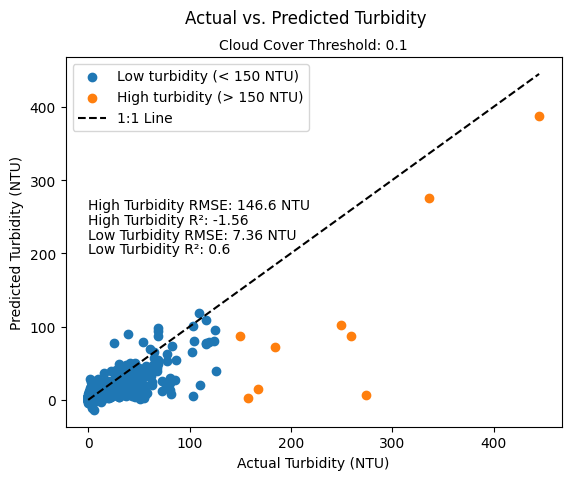

In [ ]:
plt.scatter(low_turb_targets, low_turb_outputs, label='Low turbidity (< 150 NTU)')
plt.scatter(high_turb_targets, high_turb_outputs, label='High turbidity (> 150 NTU)')

# Calculate the range for the 1:1 line
min_value = min(min(low_turb_targets), min(high_turb_targets))
max_value = max(max(low_turb_targets), max(high_turb_targets))

# Plot the 1:1 line
plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='1:1 Line')

# Labels, legend, title, and text
plt.xlabel('Actual Turbidity (NTU)')
plt.ylabel('Predicted Turbidity (NTU)')
plt.legend(loc='best')
plt.suptitle('Actual vs. Predicted Turbidity')
plt.title('Cloud Cover Threshold: 0.1', fontsize=10)
plt.text(0, 260, f'High Turbidity RMSE: {146.60} NTU')
plt.text(0, 240, f'High Turbidity R²: {round(high_turb_r2, 2)}')
plt.text(0, 220, f'Low Turbidity RMSE: {7.36} NTU')
plt.text(0, 200, f'Low Turbidity R²: {round(low_turb_r2, 2)}')

# Save and show the plot
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH, 'actual_vs_predicted_turbidity_highvslow_clean.png'), dpi=400)
plt.show()

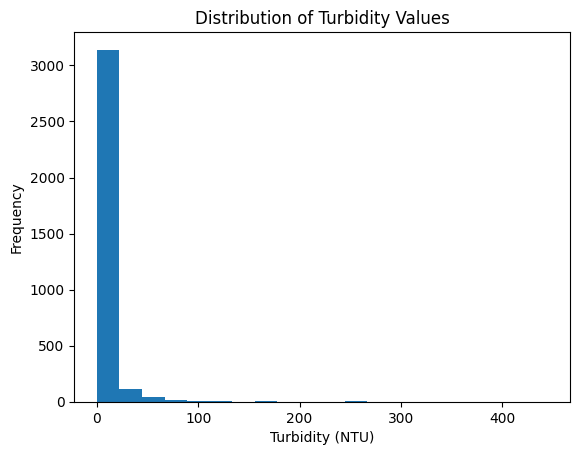

In [ ]:
plt.hist(targets_history_unnorm, bins=20)
plt.title('Distribution of Turbidity Values')
plt.xlabel('Turbidity (NTU)')
plt.ylabel('Frequency')
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'turbidity_distribution.png'), dpi=400)
plt.show()

In [ ]:
from torchvision.models import densenet121
import torch.nn as nn

model = densenet121(pretrained=True)


In [ ]:
nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
original_conv_layer = model.features.conv0
new_conv_layer = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

# Copy weights from the original 3-channel layer to the new 4-channel layer
with torch.no_grad():
    new_conv_layer.weight[:, :3] = original_conv_layer.weight
    new_conv_layer.weight[:, 3] = original_conv_layer.weight[:, 0]

model.features.conv0 = new_conv_layer
num_features = model.classifier.in_features  # Get the number of features output from the dense layers
model.classifier = nn.Linear(num_features, 1)  # Change the output layer to a single regression output

model = model.to(device)

In [ ]:
dense_net_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'dense_net_model.pth')
criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
loss_history = []
model.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        # Move data to the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))  # Ensure targets have correct shape

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        running_loss += loss.item()
    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    loss_history.append(running_loss / len(train_loader))

torch.save(model, dense_net_model_path)

Epoch [1/30], Loss: 0.9682402650527121
Epoch [2/30], Loss: 1.0167676012463975
Epoch [3/30], Loss: 0.9422901783976259
Epoch [4/30], Loss: 0.883980911501358
Epoch [5/30], Loss: 0.9100445023064978
Epoch [6/30], Loss: 0.8283678519151856
Epoch [7/30], Loss: 0.8275960807345415
Epoch [8/30], Loss: 0.781402054853274
Epoch [9/30], Loss: 0.7375127529217438
Epoch [10/30], Loss: 0.6990344706726702
Epoch [11/30], Loss: 0.6622784340032265
Epoch [12/30], Loss: 0.641184642447524
Epoch [13/30], Loss: 0.6520025868806543
Epoch [14/30], Loss: 0.5999198553540062
Epoch [15/30], Loss: 0.5702524141510993
Epoch [16/30], Loss: 0.547117816088231
Epoch [17/30], Loss: 0.4810991387849932
Epoch [18/30], Loss: 0.5019793991338123
Epoch [19/30], Loss: 0.4983810246810674
Epoch [20/30], Loss: 0.4308321814422616
Epoch [21/30], Loss: 0.4483198651812222
Epoch [22/30], Loss: 0.4323364518734328
Epoch [23/30], Loss: 0.3843299488193895
Epoch [24/30], Loss: 0.3836734357499406
Epoch [25/30], Loss: 0.4561367840216491
Epoch [26/30]

In [ ]:
dense_net_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'dense_net_model.pth')
model = torch.load(dense_net_model_path)
model.eval()  # Ensure model is in evaluation mode if loaded
print(f"Model loaded successfully from {dense_net_model_path}")

<ipython-input-149-7491fd4f94a6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(dense_net_model_path)


Model loaded successfully from drive/MyDrive/DL_proj/dense_net_model.pth


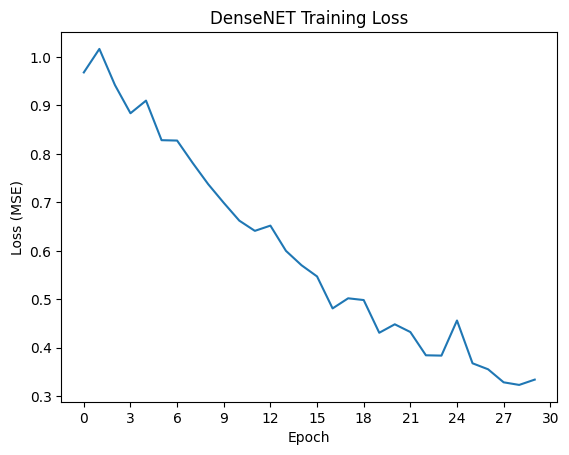

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.xticks(np.arange(0, num_epochs+1, 3))
plt.title('DenseNET Training Loss')
# plt.vlines(20, 0, 1, color='red', linestyle='--', label='Early stopping')
# plt.legend()
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'dense_net_training_loss.png'), dpi=400)
plt.show()

In [ ]:
# Evaluation on the test set
model.eval()
test_loss = 0.0

outputs_history = []
targets_history = []

with torch.no_grad():
    for rasters, targets in test_loader:
        rasters, targets = rasters.to(device), targets.to(device)

        # Forward pass
        outputs = model(rasters)
        loss = criterion(outputs, targets.view(-1, 1))  # Calculate loss

        test_loss += loss.item()

        # Append outputs and targets to lists
        outputs_history.extend(outputs.cpu().numpy())  # Move outputs to CPU and convert to numpy
        targets_history.extend(targets.cpu().numpy())  # Move targets to CPU and convert to numpy


print(f'Test Loss: {test_loss / len(test_loader)}')

Test Loss: 0.7804451133523669


In [ ]:
# Unnormalize targets
outputs_history_unnorm = reverse_zscore_normalize_target(np.array(outputs_history), target_mean, target_std)
targets_history_unnorm = reverse_zscore_normalize_target(np.array(targets_history), target_mean, target_std)

In [ ]:
rmse = np.sqrt(mean_squared_error(targets_history_unnorm, outputs_history_unnorm))
print(f'RMSE: {rmse}')

r2 = r2_score(targets_history_unnorm, outputs_history_unnorm)
print(f'R^2 Score: {r2}')

RMSE: 15.084918022155762
R^2 Score: 0.2951239347457886


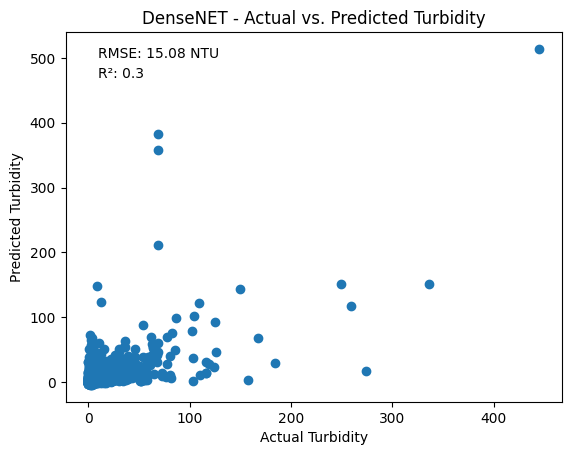

In [ ]:
plt.scatter(targets_history_unnorm, outputs_history_unnorm)
plt.xlabel('Actual Turbidity')
plt.ylabel('Predicted Turbidity')
plt.title('DenseNET - Actual vs. Predicted Turbidity')
plt.text(10, 500, f'RMSE: {15.08} NTU')
plt.text(10, 470, f'R²: {round(r2, 2)}')
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'DenseNET_actual_vs_predicted_turbidity.png'), dpi=400)
plt.show()

In [ ]:
high_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value > 150]
low_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value <= 150]
high_turb_targets = [targets_history_unnorm[i] for i in high_turb_inds]
low_turb_targets = [targets_history_unnorm[i] for i in low_turb_inds]
high_turb_outputs = [outputs_history_unnorm[i] for i in high_turb_inds]
low_turb_outputs = [outputs_history_unnorm[i] for i in low_turb_inds]

high_turb_rmse = np.sqrt(mean_squared_error(high_turb_targets, high_turb_outputs))
print(f'RMSE: {high_turb_rmse}')

low_turb_rmse = np.sqrt(mean_squared_error(low_turb_targets, low_turb_outputs))
print(f'RMSE: {low_turb_rmse}')

high_turb_r2 = r2_score(high_turb_targets, high_turb_outputs)
print(f'R² Score: {high_turb_r2}')

low_turb_r2 = r2_score(low_turb_targets, low_turb_outputs)
print(f'R² Score: {low_turb_r2}')

RMSE: 146.24853515625
RMSE: 13.052962303161621
R² Score: -1.5482210538743035
R² Score: -0.17505246681672726


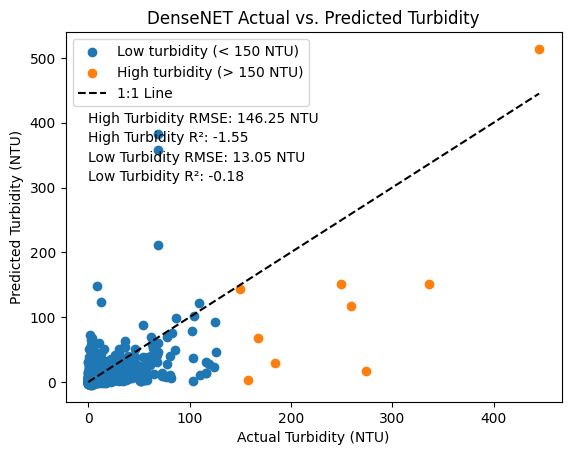

In [ ]:
plt.scatter(low_turb_targets, low_turb_outputs, label='Low turbidity (< 150 NTU)')
plt.scatter(high_turb_targets, high_turb_outputs, label='High turbidity (> 150 NTU)')

# Calculate the range for the 1:1 line
min_value = min(min(low_turb_targets), min(high_turb_targets))
max_value = max(max(low_turb_targets), max(high_turb_targets))

# Plot the 1:1 line
plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='1:1 Line')

# Labels, legend, title, and text
plt.xlabel('Actual Turbidity (NTU)')
plt.ylabel('Predicted Turbidity (NTU)')
plt.legend(loc='best')
plt.title('DenseNET Actual vs. Predicted Turbidity')
plt.text(0, 400, f'High Turbidity RMSE: {146.25} NTU')
plt.text(0, 370, f'High Turbidity R²: {round(high_turb_r2, 2)}')
plt.text(0, 340, f'Low Turbidity RMSE: {13.05} NTU')
plt.text(0, 310, f'Low Turbidity R²: {round(low_turb_r2, 2)}')

# Save and show the plot
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH, 'DenseNET_actual_vs_predicted_turbidity_highvslow.png'), dpi=400)
plt.show()

# Vision Transformers
We use the ViT-B/16 model to make turbidity predictions from 4-band satellite imagery

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
# from torchvision.models import vit_b_16  # Using ViT-B/16 as an example

import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=4, patch_size=16, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # x: (batch_size, channels, height, width)
        x = self.conv(x)  # Shape: (batch_size, embed_dim, num_patches_height, num_patches_width)
        x = x.flatten(2)  # Shape: (batch_size, embed_dim, num_patches_height * num_patches_width)
        x = x.transpose(1, 2)  # Shape: (batch_size, num_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert (
            self.head_dim * num_heads == embed_dim
        ), "Embedding dimension must be divisible by number of heads"

        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.out_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, num_patches, embed_dim = x.shape

        # Linear projections
        q = self.q_linear(x)
        k = self.k_linear(x)
        v = self.v_linear(x)

        # Reshape to (batch_size, num_heads, num_patches, head_dim)
        q = q.view(batch_size, num_patches, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, num_patches, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, num_patches, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # Shape: (batch_size, num_heads, num_patches, num_patches)
        attn = F.softmax(scores, dim=-1)

        out = (attn @ v).transpose(1, 2).contiguous().view(batch_size, num_patches, embed_dim)
        return self.out_linear(out)

class FeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForward(embed_dim, ff_dim)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output = self.attention(x)
        x = self.ln1(x + attn_output)  # Residual connection
        ff_output = self.feed_forward(x)
        return self.ln2(x + ff_output)  # Residual connection

class VisionTransformer(nn.Module):
    def __init__(self, in_channels=4, patch_size=16, embed_dim=768, num_heads=8, ff_dim=2048, num_layers=6, num_classes=1):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)  # Shape: (batch_size, num_patches, embed_dim)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        # Take the output of the [CLS] token or mean pooling for classification
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)

# Instantiate model
vit_model = VisionTransformer(in_channels=4, num_classes=1)

In [ ]:
class RasterDataset(Dataset):
    def __init__(self, rasters, targets, target_size=(224, 224)):
        self.rasters = rasters
        self.targets = targets
        self.target_size = target_size
        # self.transform = transforms.Compose([
        #     transforms.ToPILImage(),
        #     transforms.Resize(self.target_size),
        #     transforms.ToTensor()
        # ])

    def __len__(self):
        return len(self.rasters)

    def __getitem__(self, idx):
        raster = self.rasters.iloc[idx]
        target = self.targets.iloc[idx]

        # Resize and transform raster
        raster = resize_and_pad_raster(raster, (self.target_size[0], self.target_size[1]))
        raster_tensor = torch.tensor(raster, dtype=torch.float32)

        # raster_tensor = self.transform(raster)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        return raster_tensor, target_tensor

train_dataset = RasterDataset(X_train, y_train)
test_dataset = RasterDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 1e-3

# Initialize the Vision Transformer model
vit_model = VisionTransformer(in_channels=4, num_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(vit_model.parameters(), lr=learning_rate)

loss_history = []
vit_model.train()

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        # Ensure targets have the correct shape
        targets = targets.view(-1, 1)
        # Forward pass
        outputs = vit_model(images)

        # Calculate loss
        loss = criterion(outputs, targets)
        running_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    loss_history.append(running_loss / len(train_loader))

# Save the trained model
vit_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'vit_model.pth')
torch.save(vit_model, vit_model_path)
# torch.save(vit_model.state_dict(), 'vit_model.pth')

Epoch [1/20], Loss: 1.4409
Epoch [2/20], Loss: 1.0044
Epoch [3/20], Loss: 0.9977
Epoch [4/20], Loss: 0.9891
Epoch [5/20], Loss: 0.9877
Epoch [6/20], Loss: 0.9854
Epoch [7/20], Loss: 0.9758
Epoch [8/20], Loss: 0.9736
Epoch [9/20], Loss: 0.9717
Epoch [10/20], Loss: 0.9728
Epoch [11/20], Loss: 0.9714
Epoch [12/20], Loss: 0.9711
Epoch [13/20], Loss: 0.9751
Epoch [14/20], Loss: 0.9718
Epoch [15/20], Loss: 0.9718
Epoch [16/20], Loss: 0.9713
Epoch [17/20], Loss: 0.9727
Epoch [18/20], Loss: 0.9721
Epoch [19/20], Loss: 0.9724
Epoch [20/20], Loss: 0.9725


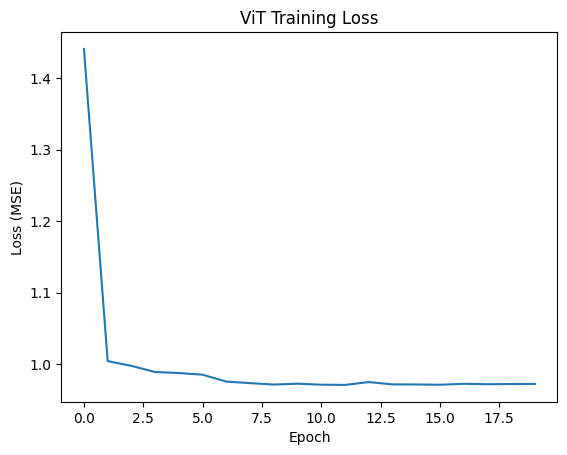

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
# plt.xticks(np.arange(0, num_epochs+1, 3))
plt.title('ViT Training Loss')
# plt.vlines(20, 0, 1, color='red', linestyle='--', label='Early stopping')
# plt.legend()
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'ViT_training_loss.png'), dpi=400)
plt.show()

In [ ]:
# Evaluation on the test set
model.eval()
test_loss = 0.0

outputs_history = []
targets_history = []

with torch.no_grad():
    for rasters, targets in test_loader:
        rasters, targets = rasters.to(device), targets.to(device)

        # Forward pass
        outputs = model(rasters)
        loss = criterion(outputs, targets.view(-1, 1))  # Calculate loss

        test_loss += loss.item()

        # Append outputs and targets to lists
        outputs_history.extend(outputs.cpu().numpy())  # Move outputs to CPU and convert to numpy
        targets_history.extend(targets.cpu().numpy())  # Move targets to CPU and convert to numpy


print(f'Test Loss: {test_loss / len(test_loader)}')

Test Loss: 1.8443264423381716


In [ ]:
# Unnormalize targets
outputs_history_unnorm = reverse_zscore_normalize_target(np.array(outputs_history), target_mean, target_std)
targets_history_unnorm = reverse_zscore_normalize_target(np.array(targets_history), target_mean, target_std)

In [ ]:
rmse = np.sqrt(mean_squared_error(targets_history_unnorm, outputs_history_unnorm))
print(f'RMSE: {rmse}')

r2 = r2_score(targets_history_unnorm, outputs_history_unnorm)
print(f'R^2 Score: {r2}')

RMSE: 23.202411651611328
R^2 Score: -0.6676045656204224


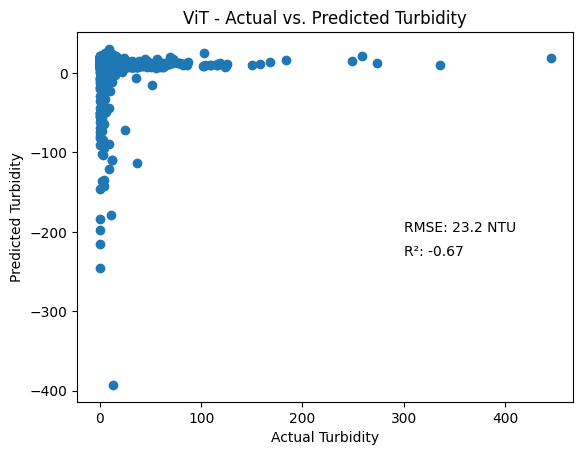

In [ ]:
plt.scatter(targets_history_unnorm, outputs_history_unnorm)
plt.xlabel('Actual Turbidity')
plt.ylabel('Predicted Turbidity')
plt.title('ViT - Actual vs. Predicted Turbidity')
plt.text(300, -200, f'RMSE: {23.20} NTU')
plt.text(300, -230, f'R²: {round(r2, 2)}')
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'ViT_actual_vs_predicted_turbidity.png'), dpi=400)
plt.show()

In [ ]:
high_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value > 150]
low_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value <= 150]
high_turb_targets = [targets_history_unnorm[i] for i in high_turb_inds]
low_turb_targets = [targets_history_unnorm[i] for i in low_turb_inds]
high_turb_outputs = [outputs_history_unnorm[i] for i in high_turb_inds]
low_turb_outputs = [outputs_history_unnorm[i] for i in low_turb_inds]

high_turb_rmse = np.sqrt(mean_squared_error(high_turb_targets, high_turb_outputs))
print(f'RMSE: {high_turb_rmse}')

low_turb_rmse = np.sqrt(mean_squared_error(low_turb_targets, low_turb_outputs))
print(f'RMSE: {low_turb_rmse}')

high_turb_r2 = r2_score(high_turb_targets, high_turb_outputs)
print(f'R² Score: {high_turb_r2}')

low_turb_r2 = r2_score(low_turb_targets, low_turb_outputs)
print(f'R² Score: {low_turb_r2}')

RMSE: 249.3811798095703
RMSE: 19.281421661376953
R² Score: -6.40937296647124
R² Score: -1.5639949254513645


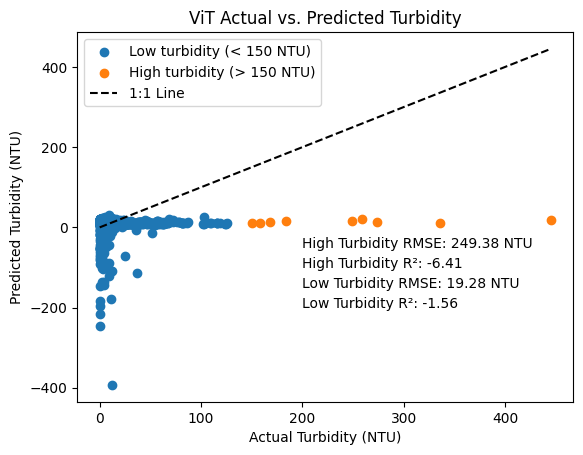

In [ ]:
plt.scatter(low_turb_targets, low_turb_outputs, label='Low turbidity (< 150 NTU)')
plt.scatter(high_turb_targets, high_turb_outputs, label='High turbidity (> 150 NTU)')

# Calculate the range for the 1:1 line
min_value = min(min(low_turb_targets), min(high_turb_targets))
max_value = max(max(low_turb_targets), max(high_turb_targets))

# Plot the 1:1 line
plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='1:1 Line')

# Labels, legend, title, and text
plt.xlabel('Actual Turbidity (NTU)')
plt.ylabel('Predicted Turbidity (NTU)')
plt.legend(loc='best')
plt.title('ViT Actual vs. Predicted Turbidity')
plt.text(200, -50, f'High Turbidity RMSE: {249.38} NTU')
plt.text(200, -100, f'High Turbidity R²: {round(high_turb_r2, 2)}')
plt.text(200, -150, f'Low Turbidity RMSE: {19.28} NTU')
plt.text(200, -200, f'Low Turbidity R²: {round(low_turb_r2, 2)}')

# Save and show the plot
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH, 'ViT_actual_vs_predicted_turbidity_highvslow.png'), dpi=400)
plt.show()

##Test pretrained ViT-B16 model

In [ ]:
from torchvision.models import vit_b_16

class VisionTransformerModel(nn.Module):
    def __init__(self, num_classes=1):
        super(VisionTransformerModel, self).__init__()

        # Load the pretrained Vision Transformer model
        self.vit = vit_b_16(weights='IMAGENET1K_V1')  # Pretrained on ImageNet

        # Modify the input layer to accept 4 channels
        self.vit.conv_proj = nn.Conv2d(
            in_channels=4,          # Change from 3 to 4 channels
            out_channels=self.vit.conv_proj.out_channels,
            kernel_size=self.vit.conv_proj.kernel_size,
            stride=self.vit.conv_proj.stride,
            padding=self.vit.conv_proj.padding,
            bias=self.vit.conv_proj.bias is not None
        )

        # Save the input dimension of the original classification head
        self.input_dim = self.vit.heads[0].in_features

        # Remove the original classification head
        self.vit.heads = nn.Identity()  # If the original classifier is named 'heads'

        # Create a new regression head
        self.regression_head = nn.Linear(self.input_dim, num_classes)

    def forward(self, x):
        # Extract features from the Vision Transformer
        features = self.vit(x)
        # Apply the regression head
        return self.regression_head(features)

In [ ]:
# Initialize the Vision Transformer model
vit_model = VisionTransformerModel()
vit_model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.001)

# Training the Vision Transformer
num_epochs = 20
loss_history_vit = []

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0

    for i, (rasters, targets) in enumerate(train_loader):
        rasters, targets = rasters.to(device), targets.to(device)

        # Zero grad
        optimizer.zero_grad()

        # Forward
        outputs = vit_model(rasters)
        loss = criterion(outputs, targets.view(-1, 1))  # Ensure targets have the right shape

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')
    loss_history_vit.append(running_loss / len(train_loader))

# Save the trained Vision Transformer model
vit_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'vit_model-b16.pth')
torch.save(vit_model.state_dict(), vit_model_path)

Epoch [1/20], Loss: 1.154935320643218
Epoch [2/20], Loss: 0.9915074778266215
Epoch [3/20], Loss: 0.983836702908875
Epoch [4/20], Loss: 0.9654054345527405
Epoch [5/20], Loss: 0.956380608210866
Epoch [6/20], Loss: 0.9467297050406773
Epoch [7/20], Loss: 0.9419870468293223
Epoch [8/20], Loss: 0.9377624406145092
Epoch [9/20], Loss: 0.924547769967021
Epoch [10/20], Loss: 0.9217796378978417
Epoch [11/20], Loss: 0.9146686733464162
Epoch [12/20], Loss: 0.911904677592717
Epoch [13/20], Loss: 0.933418089648682
Epoch [14/20], Loss: 0.9006653859783588
Epoch [15/20], Loss: 0.9330450164457186
Epoch [16/20], Loss: 0.886026678116698
Epoch [17/20], Loss: 0.8577947749279475
Epoch [18/20], Loss: 0.8475609051429056
Epoch [19/20], Loss: 0.9500350668384698
Epoch [20/20], Loss: 0.9439859106717854


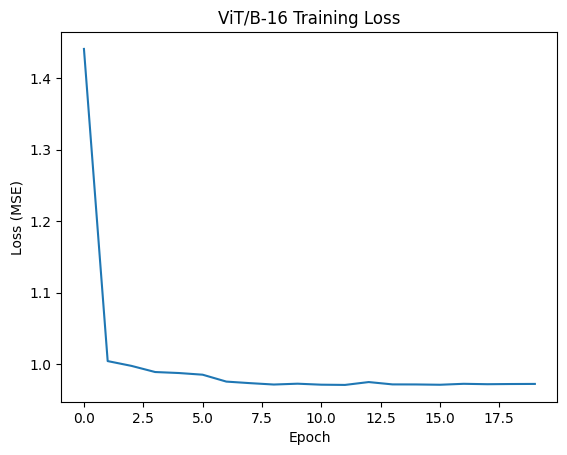

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
# plt.xticks(np.arange(0, num_epochs+1, 3))
plt.title('ViT/B-16 Training Loss')
# plt.vlines(20, 0, 1, color='red', linestyle='--', label='Early stopping')
# plt.legend()
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'ViT-B-16_training_loss.png'), dpi=400)
plt.show()

In [ ]:
# Evaluation on the test set
vit_model.eval()
test_loss = 0.0

outputs_history = []
targets_history = []

with torch.no_grad():
    for rasters, targets in test_loader:
        rasters, targets = rasters.to(device), targets.to(device)

        # Forward pass
        outputs = vit_model(rasters)
        loss = criterion(outputs, targets.view(-1, 1))  # Calculate loss

        test_loss += loss.item()

        # Append outputs and targets to lists
        outputs_history.extend(outputs.cpu().numpy())  # Move outputs to CPU and convert to numpy
        targets_history.extend(targets.cpu().numpy())  # Move targets to CPU and convert to numpy


print(f'Test Loss: {test_loss / len(test_loader)}')

Test Loss: 1.081455679521674


In [ ]:
# Unnormalize targets
outputs_history_unnorm = reverse_zscore_normalize_target(np.array(outputs_history), target_mean, target_std)
targets_history_unnorm = reverse_zscore_normalize_target(np.array(targets_history), target_mean, target_std)

In [ ]:
rmse = np.sqrt(mean_squared_error(targets_history_unnorm, outputs_history_unnorm))
print(f'RMSE: {rmse}')

r2 = r2_score(targets_history_unnorm, outputs_history_unnorm)
print(f'R^2 Score: {r2}')

RMSE: 17.76218605041504
R^2 Score: 0.022718489170074463


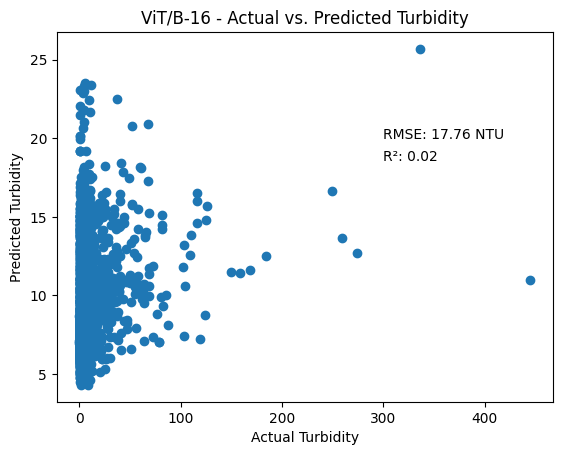

In [ ]:
plt.scatter(targets_history_unnorm, outputs_history_unnorm)
plt.xlabel('Actual Turbidity')
plt.ylabel('Predicted Turbidity')
plt.title('ViT/B-16 - Actual vs. Predicted Turbidity')
plt.text(300, 20, f'RMSE: {17.76} NTU')
plt.text(300, 18.6, f'R²: {round(r2, 2)}')
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'ViTB16_actual_vs_predicted_turbidity.png'), dpi=400)
plt.show()

In [ ]:
high_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value > 150]
low_turb_inds = [index for index, value in enumerate(targets_history_unnorm) if value <= 150]
high_turb_targets = [targets_history_unnorm[i] for i in high_turb_inds]
low_turb_targets = [targets_history_unnorm[i] for i in low_turb_inds]
high_turb_outputs = [outputs_history_unnorm[i] for i in high_turb_inds]
low_turb_outputs = [outputs_history_unnorm[i] for i in low_turb_inds]

high_turb_rmse = np.sqrt(mean_squared_error(high_turb_targets, high_turb_outputs))
print(f'RMSE: {high_turb_rmse}')

low_turb_rmse = np.sqrt(mean_squared_error(low_turb_targets, low_turb_outputs))
print(f'RMSE: {low_turb_rmse}')

high_turb_r2 = r2_score(high_turb_targets, high_turb_outputs)
print(f'R² Score: {high_turb_r2}')

low_turb_r2 = r2_score(low_turb_targets, low_turb_outputs)
print(f'R² Score: {low_turb_r2}')

RMSE: 249.80502319335938
RMSE: 12.154948234558105
R² Score: -6.434580201050818
R² Score: -0.018932192313268148


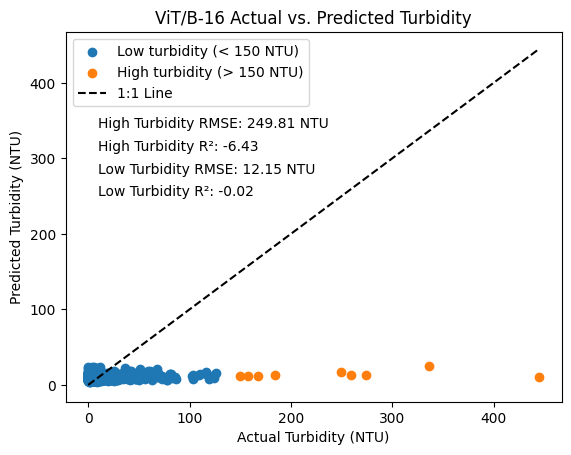

In [ ]:
plt.scatter(low_turb_targets, low_turb_outputs, label='Low turbidity (< 150 NTU)')
plt.scatter(high_turb_targets, high_turb_outputs, label='High turbidity (> 150 NTU)')

# Calculate the range for the 1:1 line
min_value = min(min(low_turb_targets), min(high_turb_targets))
max_value = max(max(low_turb_targets), max(high_turb_targets))

# Plot the 1:1 line
plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='1:1 Line')

# Labels, legend, title, and text
plt.xlabel('Actual Turbidity (NTU)')
plt.ylabel('Predicted Turbidity (NTU)')
plt.legend(loc='best')
plt.title('ViT/B-16 Actual vs. Predicted Turbidity')
plt.text(10, 340, f'High Turbidity RMSE: {249.81} NTU')
plt.text(10, 310, f'High Turbidity R²: {round(high_turb_r2, 2)}')
plt.text(10, 280, f'Low Turbidity RMSE: {12.15} NTU')
plt.text(10, 250, f'Low Turbidity R²: {round(low_turb_r2, 2)}')

# Save and show the plot
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH, 'ViTB16_actual_vs_predicted_turbidity_highvslow.png'), dpi=400)
plt.show()